The purpose of this code is to provide some information of how to classify an image. The goal is to classify images into one of two categories using different strategies, including a basic CNN from scratch, a deeper CNN model for more complex tasks, and a pretrained model for leveraging state-of-the-art performance via transfer learning. <br />


Different Models: <br />
= Standard Model: A basic CNN suitable for tasks where computational resources are limited or for building simple models from scratch. <br />
= HealthApp Model: A slightly deeper CNN that can learn more complex patterns in the data and is ideal for slightly more complex tasks. <br />
= Pretrained Model: A transfer learning approach using a state-of-the-art pretrained model (EfficientNetB0), ideal for more advanced tasks where high accuracy and feature extraction are crucial. <br />

Some resourced used: 
- https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb
- https://www.kaggle.com/code/muhammadfaizan65/knee-arthritis-detection-using-efficientnetb0/notebook
- data from https://github.com/LIamB12/health-app-backend/blob/main/app.py 

# 1. Install Dependencies and Setup

I Will provide a conda env.

In [32]:
import tensorflow as tf
import os

In [33]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, Trues

In [34]:
# tf.config.list_physical_devices('GPU')

# 2. Remove dodgy images

In [35]:
import cv2
import imghdr

In [36]:
data_dir = '/workspaces/ATAi_advance_notebooks/arthritis_data/all_images/'


In [37]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [38]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [39]:
import numpy as np
from matplotlib import pyplot as plt

In [40]:
data = tf.keras.utils.image_dataset_from_directory('/workspaces/ATAi_advance_notebooks/arthritis_data/all_images/')

Found 2060 files belonging to 2 classes.


In [41]:
data_iterator = data.as_numpy_iterator()

In [42]:
batch = data_iterator.next()

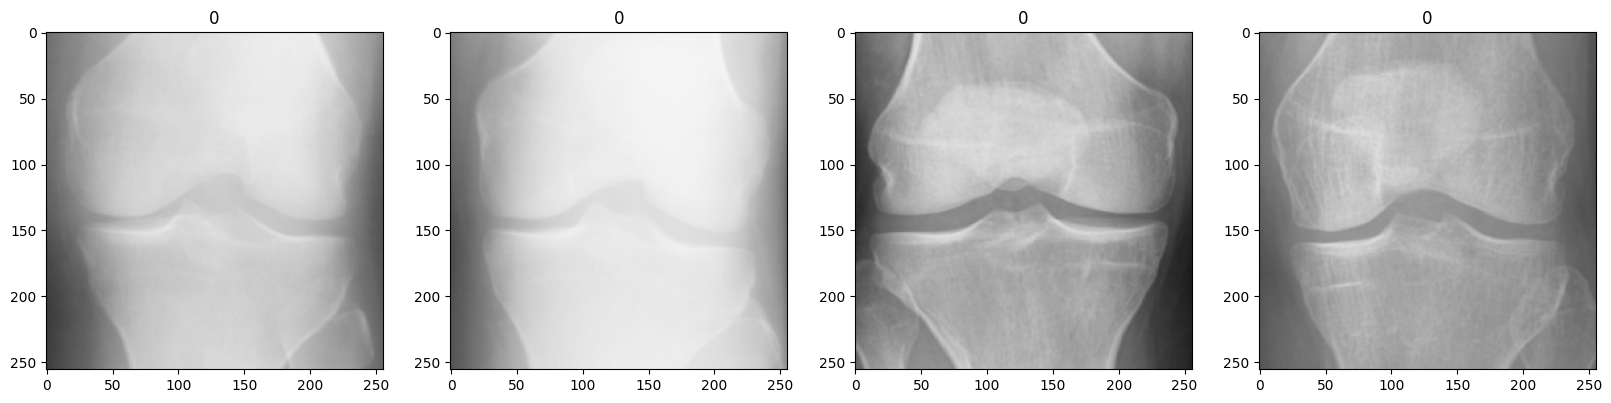

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [44]:
data = data.map(lambda x,y: (x/255, y))

In [45]:
data.as_numpy_iterator().next()

(array([[[[0.3647059 , 0.3647059 , 0.3647059 ],
          [0.37426472, 0.37426472, 0.37426472],
          [0.38186276, 0.38186276, 0.38186276],
          ...,
          [0.29558823, 0.29558823, 0.29558823],
          [0.28651962, 0.28651962, 0.28651962],
          [0.27058825, 0.27058825, 0.27058825]],
 
         [[0.37107843, 0.37107843, 0.37107843],
          [0.37545955, 0.37545955, 0.37545955],
          [0.38405332, 0.38405332, 0.38405332],
          ...,
          [0.28901654, 0.28901654, 0.28901654],
          [0.28651962, 0.28651962, 0.28651962],
          [0.27058825, 0.27058825, 0.27058825]],
 
         [[0.37254903, 0.37254903, 0.37254903],
          [0.38011643, 0.38011643, 0.38011643],
          [0.38624388, 0.38624388, 0.38624388],
          ...,
          [0.2841299 , 0.2841299 , 0.2841299 ],
          [0.27674633, 0.27674633, 0.27674633],
          [0.26519608, 0.26519608, 0.26519608]],
 
         ...,
 
         [[0.07205883, 0.07205883, 0.07205883],
          [0.10491

What model do you want to try? 

In [46]:
model_set_up = "basic" 

# 5. Split Data

In [47]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [48]:
train_size

45

In [49]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [50]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


In [76]:
model_set_up = "pretrained_binary"

if model_set_up == "basic": 
    model = Sequential()

    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

elif (model_set_up == "pretrained_binary"):

    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras import layers, models

    base_model = VGG16(input_shape = (256,256, 3), # Shape of our images
                       include_top = False, # Leave out the last fully connected layer
                       weights = 'imagenet')
    

    for layer in base_model.layers:
        layer.trainable = False

    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(base_model.output)

    # Add a fully connected layer with 512 hidden units and ReLU activation
    x = layers.Dense(512, activation='relu')(x)

    # Add a dropout rate of 0.5
    x = layers.Dropout(0.5)(x)

    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(base_model.input, x)

    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['accuracy'])



else : 
    print("no model selected")

/opt/conda/envs/arthritis_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [53]:
# model.summary()

# 7. Train

In [99]:
# Create a log directory for TensorBoard
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


if model_set_up == "basic": 
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
elif (model_set_up == "pretrained_binary"):
    # hist = model.fit(train, validation_data = val, steps_per_epoch = 100, epochs = 10) # original, but not enough data
    hist = model.fit(train, epochs = 7, validation_data = val, callbacks=[tensorboard_callback])


else: 
    print("no model selected")


# val_accuracy for overfitting. 
    

Epoch 1/7


45/45 [==============================] - 114s 3s/step - loss: 0.1387 - accuracy: 0.9486 - val_loss: 0.1086 - val_accuracy: 0.9663
Epoch 2/7
45/45 [==============================] - 114s 3s/step - loss: 0.1395 - accuracy: 0.9500 - val_loss: 0.0948 - val_accuracy: 0.9663
Epoch 3/7
45/45 [==============================] - 114s 3s/step - loss: 0.1298 - accuracy: 0.9549 - val_loss: 0.1816 - val_accuracy: 0.9399
Epoch 4/7
45/45 [==============================] - 114s 3s/step - loss: 0.1149 - accuracy: 0.9549 - val_loss: 0.1189 - val_accuracy: 0.9615
Epoch 5/7
45/45 [==============================] - 114s 3s/step - loss: 0.1245 - accuracy: 0.9535 - val_loss: 0.0828 - val_accuracy: 0.9688
Epoch 6/7
45/45 [==============================] - 114s 3s/step - loss: 0.1107 - accuracy: 0.9625 - val_loss: 0.0905 - val_accuracy: 0.9712
Epoch 7/7
45/45 [==============================] - 114s 3s/step - loss: 0.1156 - accuracy: 0.9597 - val_loss: 0.0945 - val_accuracy: 0.9712


# 8. Plot Performance

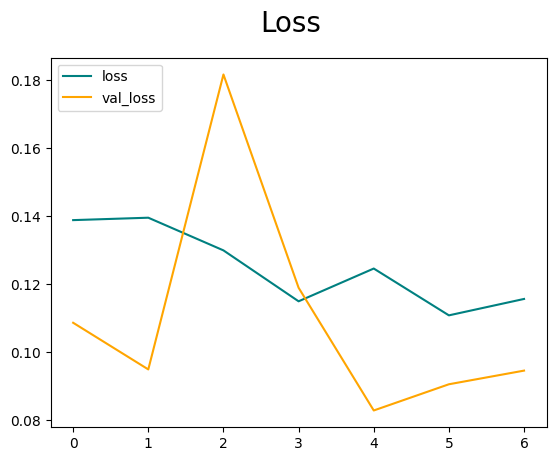

In [100]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

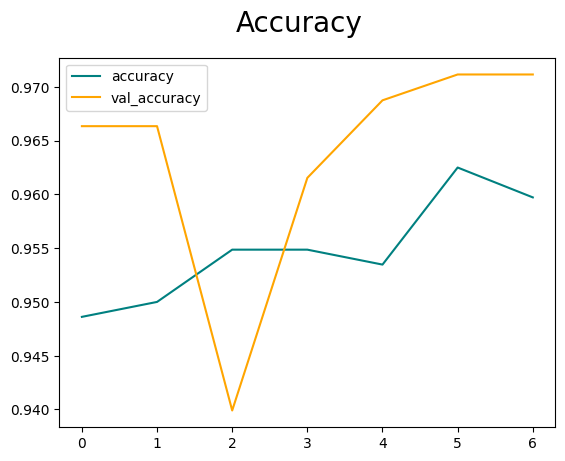

In [101]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [102]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [103]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [104]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [106]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.96428573, shape=(), dtype=float32) tf.Tensor(0.9529412, shape=(), dtype=float32) tf.Tensor(0.9635417, shape=(), dtype=float32)


# 10. Test

In [107]:
import cv2

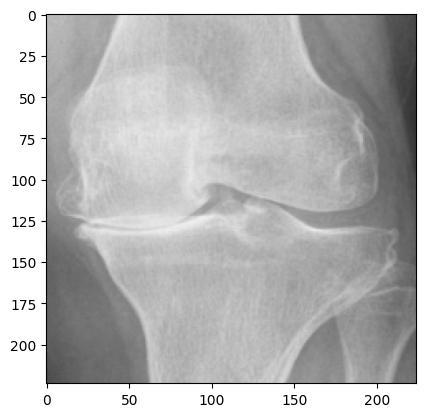

In [112]:
img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/itsarthritis.jpg"
# img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/notarthritis.jpg"


img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

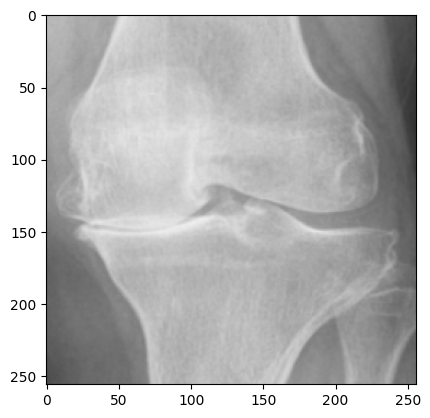

In [113]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [114]:
yhat = model.predict(np.expand_dims(resize/255, 0))

yhat

if yhat > 0.5: 
    print(f'Predicted class is Arthritis')
else:
    print(f'Predicted class is NotArthritis')

1/1 [==============================] - 0s 88ms/step
Predicted class is Arthritis


In [115]:
yhat

array([[0.8646265]], dtype=float32)

# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier_basic.h5'))

In [46]:
new_model = load_model('imageclassifier_basic.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)